# Introduction
This is some exploratory code we wrote as a 'Prove of Concept' and to get an understanding on how to get PyLucene to work.

## Playing with PyLucene and mock data

In [7]:
# This needs to be run once to get it all going
lucene.initVM(vmargs=['-Djava.awt.headless=true'])

ValueError: JVM is already running, options are ineffective

So the above code crashes if the VM is already running so we need to be a bit careful with that.

In [3]:
# Check if Lucene is found and working
import sys, lucene, unittest
from lucene import JArray
from org.apache.lucene.document import StoredField


class BinaryTestCase(unittest.TestCase):

    def binary(self, b):

        c = JArray('byte')(b)
        field = StoredField("bin", c)
        v = field.binaryValue().bytes
        assert c == v and b == [a for a in v]

    def testBinary(self):

        self.binary([66, 90, 104, 57, 49, 65, 89, 38,
                     83, 89, 105, 56, 95, 75, 0, 0, 14, -41, -128])
        self.binary([])
        self.binary([0, 0, 0])

b = BinaryTestCase()
b.testBinary()

Seems to work nice.

In [8]:
#!/usr/bin/env python

INDEX_DIR = "IndexFiles.index"

import sys, os, lucene, threading, time
from datetime import datetime

from java.nio.file import Paths
from org.apache.lucene.analysis.miscellaneous import LimitTokenCountAnalyzer
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.document import Document, Field, FieldType
from org.apache.lucene.index import \
    FieldInfo, IndexWriter, IndexWriterConfig, IndexOptions
from org.apache.lucene.store import NIOFSDirectory #,  SimpleFSDirectory
# from org.apache.lucene.store import SimpleFSDirectory


"""
This class is loosely based on the Lucene (java implementation) demo class
org.apache.lucene.demo.IndexFiles.  It will take a directory as an argument
and will index all of the files in that directory and downward recursively.
It will index on the file path, the file name and the file contents.  The
resulting Lucene index will be placed in the current directory and called
'index'.
"""

class Ticker(object):

    def __init__(self):
        self.tick = True

    def run(self):
        while self.tick:
            sys.stdout.write('.')
            sys.stdout.flush()
            time.sleep(1.0)

class IndexFiles(object):
    """Usage: python IndexFiles <doc_directory>"""

    def __init__(self, root, storeDir, analyzer):

        if not os.path.exists(storeDir):
            os.mkdir(storeDir)

        store = NIOFSDirectory(Paths.get(storeDir))
        analyzer = LimitTokenCountAnalyzer(analyzer, 1048576)
        config = IndexWriterConfig(analyzer)
        config.setOpenMode(IndexWriterConfig.OpenMode.CREATE)
        writer = IndexWriter(store, config)

        self.indexDocs(root, writer)
        ticker = Ticker()
        print ('commit index'),
        threading.Thread(target=ticker.run).start()
        writer.commit()
        writer.close()
        ticker.tick = False
        print ('done')

    def indexDocs(self, root, writer):

        t1 = FieldType()
        t1.setStored(True)
        t1.setTokenized(False)
        t1.setIndexOptions(IndexOptions.DOCS_AND_FREQS)

        t2 = FieldType()
        t2.setStored(False)
        t2.setTokenized(True)
        t2.setIndexOptions(IndexOptions.DOCS_AND_FREQS_AND_POSITIONS)

        for root, dirnames, filenames in os.walk(root):
            for filename in filenames:
                if not filename.endswith('.txt'):
                    continue
                print ("adding", filename)
                try:
                    path = os.path.join(root, filename)
                    file = open(path)
                    contents = str(file.read()) # , 'iso-8859-1')
                    file.close()
                    doc = Document()
                    doc.add(Field("name", filename, t1))
                    doc.add(Field("path", root, t1))
                    if len(contents) > 0:
                        doc.add(Field("contents", contents, t2))
                    else:
                        print ("warning: no content in %s" % filename)
                    writer.addDocument(doc)
                except Exception as e:
                    print ("Failed in indexDocs:", e)

# if __name__ == '__main__':
# if len(sys.argv) < 2:
#     print (IndexFiles.__doc__)
#     sys.exit(1)
# lucene.initVM(vmargs=['-Djava.awt.headless=true'])
print ('lucene', lucene.VERSION)
start = datetime.now()
try:
    base_dir = os.path.dirname("/Users/tobiaswilfert/Documents/University/IR/chess-db/test.ipynb")
    IndexFiles("./test/", os.path.join(base_dir, INDEX_DIR),
                StandardAnalyzer())
    end = datetime.now()
    print (end - start)
except Exception as e:
    print ("Failed: ", e)
    raise e


lucene 9.7.0
adding What are digital picture frames and how do they work .txt
adding Why You Should Order a Photo Blanket and How to Do It.txt
adding Why Should You Use Digital Photography .txt
adding What is PPI - Pixels Per Inch.txt
adding What_s new with Cellphone Cameras.txt
adding Your Digital Camera Is A Money Maker.txt
adding World Class Camera Bags Enhance Photography Experience.txt
Failed in indexDocs: 'utf-8' codec can't decode byte 0x92 in position 1589: invalid start byte
adding Your Digital Photo Developing Options.txt
adding What Is The Best Digital Camera For Me .txt
adding Why Don_t I Look Good In Pictures.txt
adding Worried about photo papers  .txt
adding What is PP in Digital Photography .txt
adding What every photo researcher ought to know about buying digital stock photos.txt
adding What is DPI - Dots Per Inch.txt
adding What are the latest advances in digital camera PDAs .txt
adding What To Look For In A Digital Camera.txt
adding Why Canon Digital Cameras Are Bette

Now we have the index what next? We need to be able to search it. We can do this with the following code:

In [1]:
#!/usr/bin/env python

INDEX_DIR = "./IndexFiles.index/"

import sys, os, lucene

from java.nio.file import Paths
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.store import NIOFSDirectory
from org.apache.lucene.search import IndexSearcher

"""
This script is loosely based on the Lucene (java implementation) demo class
org.apache.lucene.demo.SearchFiles.  It will prompt for a search query, then it
will search the Lucene index in the current directory called 'index' for the
search query entered against the 'contents' field.  It will then display the
'path' and 'name' fields for each of the hits it finds in the index.  Note that
search.close() is currently commented out because it causes a stack overflow in
some cases.
"""
def run(searcher, analyzer, command):
    # while True:
        # print()
        # print("Hit enter with no input to quit.")
        # command = input("Query:")
        # if command == '':
        #     return

    print ("Searching for:", command)
    query = QueryParser("contents", analyzer).parse(command)
    scoreDocs = searcher.search(query, 50).scoreDocs
    print ("%s total matching documents." % len(scoreDocs))

    for scoreDoc in scoreDocs:
        doc = searcher.doc(scoreDoc.doc)
        print ('path:', doc.get("path"), 'name:', doc.get("name"))


# if __name__ == '__main__':
lucene.initVM(vmargs=['-Djava.awt.headless=true'])
print( 'lucene', lucene.VERSION)
base_dir = os.path.dirname("/Users/tobiaswilfert/Documents/University/IR/chess-db/test.ipynb")
directory = NIOFSDirectory(Paths.get(os.path.join(base_dir, INDEX_DIR)))
searcher = IndexSearcher(DirectoryReader.open(directory))
analyzer = StandardAnalyzer()
run(searcher, analyzer, command="Wedding")
del searcher


lucene 9.7.0
Searching for: Wedding
1 total matching documents.
path: ./test/ name: Wedding Photography Secrets - Tips For Taking The Best Wedding Day Photos Possible.txt


In [3]:
base_dir = os.path.dirname("/Users/tobiaswilfert/Documents/University/IR/chess-db/test.ipynb")
directory = NIOFSDirectory(Paths.get(os.path.join(base_dir, INDEX_DIR)))
searcher = IndexSearcher(DirectoryReader.open(directory))
analyzer = StandardAnalyzer()
run(searcher, analyzer, command="DigiFrame DF-560")

Searching for: DigiFrame DF-560
1 total matching documents.
path: ./test/ name: What are digital picture frames and how do they work .txt


In [4]:
base_dir = os.path.dirname("/Users/tobiaswilfert/Documents/University/IR/chess-db/test.ipynb")
directory = NIOFSDirectory(Paths.get(os.path.join(base_dir, INDEX_DIR)))
searcher = IndexSearcher(DirectoryReader.open(directory))
analyzer = StandardAnalyzer()
run(searcher, analyzer, command="the")

Searching for: the
18 total matching documents.
path: ./test/ name: What Is The Best Digital Camera For Me .txt
path: ./test/ name: Wedding Photography Secrets - Tips For Taking The Best Wedding Day Photos Possible.txt
path: ./test/ name: What is PPI - Pixels Per Inch.txt
path: ./test/ name: What are digital picture frames and how do they work .txt
path: ./test/ name: What To Look For In A Digital Camera.txt
path: ./test/ name: Why Don_t I Look Good In Pictures.txt
path: ./test/ name: Why Canon Digital Cameras Are Better.txt
path: ./test/ name: Why I ve gone Digital - And Still Keep My Old Camera.txt
path: ./test/ name: What_s new with Cellphone Cameras.txt
path: ./test/ name: What is DPI - Dots Per Inch.txt
path: ./test/ name: What is PP in Digital Photography .txt
path: ./test/ name: Your Digital Photo Developing Options.txt
path: ./test/ name: Why Should You Use Digital Photography .txt
path: ./test/ name: What are the latest advances in digital camera PDAs .txt
path: ./test/ name: 

## Playing with the chess libraries

In [6]:
import io

import chess.pgn

pgn = io.StringIO("1. e4 { [%clk 0:01:00] } 1... c5 { [%clk 0:01:00] } 2. Nf3 { [%clk 0:00:59] } 2... Nc6 { [%clk 0:01:00] } 3. c3 { [%clk 0:00:58] } 3... e5 { [%clk 0:00:59] } 4. d4 { [%clk 0:00:58] } 4... cxd4 { [%clk 0:00:59] } 5. cxd4 { [%clk 0:00:58] } 5... exd4 { [%clk 0:00:59] } 6. Nxd4 { [%clk 0:00:57] } 6... Nf6 { [%clk 0:00:59] } 7. Nxc6 { [%clk 0:00:56] } 7... bxc6 { [%clk 0:00:59] } 8. Nc3 { [%clk 0:00:56] } 8... Bb4 { [%clk 0:00:58] } 9. f3 { [%clk 0:00:54] } 9... O-O { [%clk 0:00:57] } 10. Bd2 { [%clk 0:00:53] } 10... a5 { [%clk 0:00:57] } 11. a3 { [%clk 0:00:52] } 11... Be7 { [%clk 0:00:56] } 12. Bc4 { [%clk 0:00:51] } 12... Ba6 { [%clk 0:00:56] } 13. Qe2 { [%clk 0:00:50] } 13... Bxc4 { [%clk 0:00:54] } 14. Qxc4 { [%clk 0:00:50] } 14... Qc7 { [%clk 0:00:54] } 15. O-O { [%clk 0:00:49] } 15... Rac8 { [%clk 0:00:53] } 16. Qd3 { [%clk 0:00:48] } 16... Rfd8 { [%clk 0:00:52] } 17. Bg5 { [%clk 0:00:45] } 17... h6 { [%clk 0:00:51] } 18. Bxf6 { [%clk 0:00:44] } 18... Bxf6 { [%clk 0:00:51] } 19. Rad1 { [%clk 0:00:43] } 19... Qb6+ { [%clk 0:00:49] } 20. Kh1 { [%clk 0:00:37] } 20... Qxb2 { [%clk 0:00:48] } 21. Ne2 { [%clk 0:00:37] } 21... c5 { [%clk 0:00:45] } 22. Rd2 { [%clk 0:00:37] } 22... Qe5 { [%clk 0:00:43] } 23. Nc1 { [%clk 0:00:34] } 23... c4 { [%clk 0:00:42] } 24. Qe2 { [%clk 0:00:34] } 24... c3 { [%clk 0:00:41] } 25. Na2 { [%clk 0:00:34] } 25... cxd2 { [%clk 0:00:40] } 26. Nc3 { [%clk 0:00:33] } 26... Qxc3 { [%clk 0:00:39] } 27. Qf2 { [%clk 0:00:32] } 27... Qc1 { [%clk 0:00:37] } 28. Qg3 { [%clk 0:00:32] } 28... Qxf1# { [%clk 0:00:36] } 0-1")

game = chess.pgn.read_game(pgn)

board = game.board()
for move in game.mainline_moves():
    print(move)
    board.push(move)  # to update and render the board

e2e4
c7c5
g1f3
b8c6
c2c3
e7e5
d2d4
c5d4
c3d4
e5d4
f3d4
g8f6
d4c6
b7c6
b1c3
f8b4
f2f3
e8g8
c1d2
a7a5
a2a3
b4e7
f1c4
c8a6
d1e2
a6c4
e2c4
d8c7
e1g1
a8c8
c4d3
f8d8
d2g5
h7h6
g5f6
e7f6
a1d1
c7b6
g1h1
b6b2
c3e2
c6c5
d1d2
b2e5
e2c1
c5c4
d3e2
c4c3
c1a2
c3d2
a2c3
e5c3
e2f2
c3c1
f2g3
c1f1


Seem to be able to parse a string representation of pgn.

In [7]:
import chess.pgn
pgn = io.StringIO("1. e4 { [%clk 0:01:00] } 1... c5 { [%clk 0:01:00] } 2. Nf3 { [%clk 0:00:59] } 2... Nc6 { [%clk 0:01:00] } 3. c3 { [%clk 0:00:58] } 3... e5 { [%clk 0:00:59] } 4. d4 { [%clk 0:00:58] } 4... cxd4 { [%clk 0:00:59] } 5. cxd4 { [%clk 0:00:58] } 5... exd4 { [%clk 0:00:59] } 6. Nxd4 { [%clk 0:00:57] } 6... Nf6 { [%clk 0:00:59] } 7. Nxc6 { [%clk 0:00:56] } 7... bxc6 { [%clk 0:00:59] } 8. Nc3 { [%clk 0:00:56] } 8... Bb4 { [%clk 0:00:58] } 9. f3 { [%clk 0:00:54] } 9... O-O { [%clk 0:00:57] } 10. Bd2 { [%clk 0:00:53] } 10... a5 { [%clk 0:00:57] } 11. a3 { [%clk 0:00:52] } 11... Be7 { [%clk 0:00:56] } 12. Bc4 { [%clk 0:00:51] } 12... Ba6 { [%clk 0:00:56] } 13. Qe2 { [%clk 0:00:50] } 13... Bxc4 { [%clk 0:00:54] } 14. Qxc4 { [%clk 0:00:50] } 14... Qc7 { [%clk 0:00:54] } 15. O-O { [%clk 0:00:49] } 15... Rac8 { [%clk 0:00:53] } 16. Qd3 { [%clk 0:00:48] } 16... Rfd8 { [%clk 0:00:52] } 17. Bg5 { [%clk 0:00:45] } 17... h6 { [%clk 0:00:51] } 18. Bxf6 { [%clk 0:00:44] } 18... Bxf6 { [%clk 0:00:51] } 19. Rad1 { [%clk 0:00:43] } 19... Qb6+ { [%clk 0:00:49] } 20. Kh1 { [%clk 0:00:37] } 20... Qxb2 { [%clk 0:00:48] } 21. Ne2 { [%clk 0:00:37] } 21... c5 { [%clk 0:00:45] } 22. Rd2 { [%clk 0:00:37] } 22... Qe5 { [%clk 0:00:43] } 23. Nc1 { [%clk 0:00:34] } 23... c4 { [%clk 0:00:42] } 24. Qe2 { [%clk 0:00:34] } 24... c3 { [%clk 0:00:41] } 25. Na2 { [%clk 0:00:34] } 25... cxd2 { [%clk 0:00:40] } 26. Nc3 { [%clk 0:00:33] } 26... Qxc3 { [%clk 0:00:39] } 27. Qf2 { [%clk 0:00:32] } 27... Qc1 { [%clk 0:00:37] } 28. Qg3 { [%clk 0:00:32] } 28... Qxf1# { [%clk 0:00:36] } 0-1")

mygame=chess.pgn.read_game(pgn)
while mygame.next():
    mygame=mygame.next()
    print(mygame.board().fen())

rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
rnbqkbnr/pp1ppppp/8/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
r1bqkbnr/pp1ppppp/2n5/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3
r1bqkbnr/pp1ppppp/2n5/2p5/4P3/2P2N2/PP1P1PPP/RNBQKB1R b KQkq - 0 3
r1bqkbnr/pp1p1ppp/2n5/2p1p3/4P3/2P2N2/PP1P1PPP/RNBQKB1R w KQkq - 0 4
r1bqkbnr/pp1p1ppp/2n5/2p1p3/3PP3/2P2N2/PP3PPP/RNBQKB1R b KQkq - 0 4
r1bqkbnr/pp1p1ppp/2n5/4p3/3pP3/2P2N2/PP3PPP/RNBQKB1R w KQkq - 0 5
r1bqkbnr/pp1p1ppp/2n5/4p3/3PP3/5N2/PP3PPP/RNBQKB1R b KQkq - 0 5
r1bqkbnr/pp1p1ppp/2n5/8/3pP3/5N2/PP3PPP/RNBQKB1R w KQkq - 0 6
r1bqkbnr/pp1p1ppp/2n5/8/3NP3/8/PP3PPP/RNBQKB1R b KQkq - 0 6
r1bqkb1r/pp1p1ppp/2n2n2/8/3NP3/8/PP3PPP/RNBQKB1R w KQkq - 1 7
r1bqkb1r/pp1p1ppp/2N2n2/8/4P3/8/PP3PPP/RNBQKB1R b KQkq - 0 7
r1bqkb1r/p2p1ppp/2p2n2/8/4P3/8/PP3PPP/RNBQKB1R w KQkq - 0 8
r1bqkb1r/p2p1ppp/2p2n2/8/4P3/2N5/PP3PPP/R1BQKB1R b KQkq - 1 8
r1bqk2r/p2p1ppp/2p2n2/8/1b2P3/2N5/PP3PPP/R1BQKB1R w

Nice we can also generate the FEN from the board after a certain number of moves in the PGN representation.

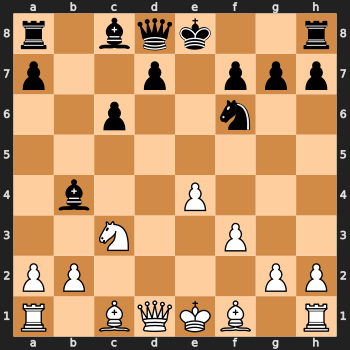

In [10]:
import chess.svg
board = chess.Board("r1bqk2r/p2p1ppp/2p2n2/8/1b2P3/2N2P2/PP4PP/R1BQKB1R b KQkq - 0 9")
chess.svg.board(board, size=350)

We can even get a nice board representation of the FEN 🥳

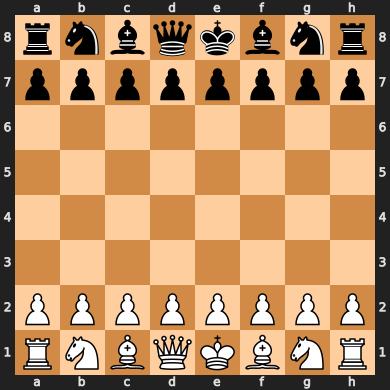

In [12]:
board = chess.Board()
display(board)

## Trying to get the games indexed

### Data exploration

In [13]:
# Read a pgn file into a list of games
pgn = open("test.pgn")
games = []
while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    games.append(game)
print(len(games))

50


In [28]:
print(games[0].headers)
games[0].mainline_moves()


Headers(Event='Rated Bullet game', Site='https://lichess.org/kLKqVm2U', Date='2023.09.01', Round='-', White='slammayjammay', Black='Zedward', Result='0-1', UTCDate='2023.09.01', UTCTime='00:00:27', WhiteElo='1982', BlackElo='1979', WhiteRatingDiff='-5', BlackRatingDiff='+6', ECO='B30', Opening='Sicilian Defense: Old Sicilian', TimeControl='60+0', Termination='Normal')


<Mainline at 0x118cc41d0 (1. e4 c5 2. Nf3 Nc6 3. c3 e5 4. d4 cxd4 5. cxd4 exd4 6. Nxd4 Nf6 7. Nxc6 bxc6 8. Nc3 Bb4 9. f3 O-O 10. Bd2 a5 11. a3 Be7 12. Bc4 Ba6 13. Qe2 Bxc4 14. Qxc4 Qc7 15. O-O Rac8 16. Qd3 Rfd8 17. Bg5 h6 18. Bxf6 Bxf6 19. Rad1 Qb6+ 20. Kh1 Qxb2 21. Ne2 c5 22. Rd2 Qe5 23. Nc1 c4 24. Qe2 c3 25. Na2 cxd2 26. Nc3 Qxc3 27. Qf2 Qc1 28. Qg3 Qxf1#)>

In [29]:
import io

import chess.pgn

pgn = io.StringIO("1. e4 { [%clk 0:01:00] } 1... c5 { [%clk 0:01:00] } 2. Nf3 { [%clk 0:00:59] } 2... Nc6 { [%clk 0:01:00] } 3. c3 { [%clk 0:00:58] } 3... e5 { [%clk 0:00:59] } 4. d4 { [%clk 0:00:58] } 4... cxd4 { [%clk 0:00:59] } 5. cxd4 { [%clk 0:00:58] } 5... exd4 { [%clk 0:00:59] } 6. Nxd4 { [%clk 0:00:57] } 6... Nf6 { [%clk 0:00:59] } 7. Nxc6 { [%clk 0:00:56] } 7... bxc6 { [%clk 0:00:59] } 8. Nc3 { [%clk 0:00:56] } 8... Bb4 { [%clk 0:00:58] } 9. f3 { [%clk 0:00:54] } 9... O-O { [%clk 0:00:57] } 10. Bd2 { [%clk 0:00:53] } 10... a5 { [%clk 0:00:57] } 11. a3 { [%clk 0:00:52] } 11... Be7 { [%clk 0:00:56] } 12. Bc4 { [%clk 0:00:51] } 12... Ba6 { [%clk 0:00:56] } 13. Qe2 { [%clk 0:00:50] } 13... Bxc4 { [%clk 0:00:54] } 14. Qxc4 { [%clk 0:00:50] } 14... Qc7 { [%clk 0:00:54] } 15. O-O { [%clk 0:00:49] } 15... Rac8 { [%clk 0:00:53] } 16. Qd3 { [%clk 0:00:48] } 16... Rfd8 { [%clk 0:00:52] } 17. Bg5 { [%clk 0:00:45] } 17... h6 { [%clk 0:00:51] } 18. Bxf6 { [%clk 0:00:44] } 18... Bxf6 { [%clk 0:00:51] } 19. Rad1 { [%clk 0:00:43] } 19... Qb6+ { [%clk 0:00:49] } 20. Kh1 { [%clk 0:00:37] } 20... Qxb2 { [%clk 0:00:48] } 21. Ne2 { [%clk 0:00:37] } 21... c5 { [%clk 0:00:45] } 22. Rd2 { [%clk 0:00:37] } 22... Qe5 { [%clk 0:00:43] } 23. Nc1 { [%clk 0:00:34] } 23... c4 { [%clk 0:00:42] } 24. Qe2 { [%clk 0:00:34] } 24... c3 { [%clk 0:00:41] } 25. Na2 { [%clk 0:00:34] } 25... cxd2 { [%clk 0:00:40] } 26. Nc3 { [%clk 0:00:33] } 26... Qxc3 { [%clk 0:00:39] } 27. Qf2 { [%clk 0:00:32] } 27... Qc1 { [%clk 0:00:37] } 28. Qg3 { [%clk 0:00:32] } 28... Qxf1# { [%clk 0:00:36] } 0-1")
game = chess.pgn.read_game(pgn)

board = game.board()
for move in game.mainline_moves():
    print(move)
    board.push(move)  # to update and render the board

e2e4
c7c5
g1f3
b8c6
c2c3
e7e5
d2d4
c5d4
c3d4
e5d4
f3d4
g8f6
d4c6
b7c6
b1c3
f8b4
f2f3
e8g8
c1d2
a7a5
a2a3
b4e7
f1c4
c8a6
d1e2
a6c4
e2c4
d8c7
e1g1
a8c8
c4d3
f8d8
d2g5
h7h6
g5f6
e7f6
a1d1
c7b6
g1h1
b6b2
c3e2
c6c5
d1d2
b2e5
e2c1
c5c4
d3e2
c4c3
c1a2
c3d2
a2c3
e5c3
e2f2
c3c1
f2g3
c1f1


In [41]:
# Let's try to see if we can write these moves to a file.

# The root file
pgn = open("test.pgn")
games = []

while True:
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    games.append(game)
    

for game in games:
        print(game.headers['Site'])
        name = game.headers['Site']
        new_content = ""
        while game.next():
            game=game.next()
            new_content += f"{game.board().fen()}\n"
        # write to the file in the zoutput directory
        file = open(f"Users/tobiaswilfert/Documents/University/IR/chess-db/zoutput/{1}.txt", "w")
        file.write(new_content)

https://lichess.org/kLKqVm2U


FileNotFoundError: [Errno 2] No such file or directory: 'Users/tobiaswilfert/Documents/University/IR/chess-db/zoutput/1.txt'

So we can't seem to open files from a notebook? Seems like we will need to write scripts for this then :(

In [42]:
# Create a super simple index of the files in the zoutput directory
INDEX_DIR = "Chess.index"

import sys, os, lucene, threading, time
from datetime import datetime

from java.nio.file import Paths
from org.apache.lucene.analysis.miscellaneous import LimitTokenCountAnalyzer
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.document import Document, Field, FieldType
from org.apache.lucene.index import \
    FieldInfo, IndexWriter, IndexWriterConfig, IndexOptions
from org.apache.lucene.store import NIOFSDirectory #,  SimpleFSDirectory
# from org.apache.lucene.store import SimpleFSDirectory


"""
This class is loosely based on the Lucene (java implementation) demo class
org.apache.lucene.demo.IndexFiles.  It will take a directory as an argument
and will index all of the files in that directory and downward recursively.
It will index on the file path, the file name and the file contents.  The
resulting Lucene index will be placed in the current directory and called
'index'.
"""

class Ticker(object):

    def __init__(self):
        self.tick = True

    def run(self):
        while self.tick:
            sys.stdout.write('.')
            sys.stdout.flush()
            time.sleep(1.0)

class IndexFiles(object):
    """Usage: python IndexFiles <doc_directory>"""

    def __init__(self, root, storeDir, analyzer):

        if not os.path.exists(storeDir):
            os.mkdir(storeDir)

        store = NIOFSDirectory(Paths.get(storeDir))
        analyzer = LimitTokenCountAnalyzer(analyzer, 1048576)
        config = IndexWriterConfig(analyzer)
        config.setOpenMode(IndexWriterConfig.OpenMode.CREATE)
        writer = IndexWriter(store, config)

        self.indexDocs(root, writer)
        ticker = Ticker()
        print ('commit index'),
        threading.Thread(target=ticker.run).start()
        writer.commit()
        writer.close()
        ticker.tick = False
        print ('done')

    def indexDocs(self, root, writer):

        t1 = FieldType()
        t1.setStored(True)
        t1.setTokenized(False)
        t1.setIndexOptions(IndexOptions.DOCS_AND_FREQS)

        t2 = FieldType()
        t2.setStored(False)
        t2.setTokenized(True)
        t2.setIndexOptions(IndexOptions.DOCS_AND_FREQS_AND_POSITIONS)

        for root, dirnames, filenames in os.walk(root):
            for filename in filenames:
                if not filename.endswith('.txt'):
                    continue
                print ("adding", filename)
                try:
                    path = os.path.join(root, filename)
                    file = open(path)
                    contents = str(file.read()) # , 'iso-8859-1')
                    file.close()
                    doc = Document()
                    doc.add(Field("name", filename, t1))
                    doc.add(Field("path", root, t1))
                    if len(contents) > 0:
                        doc.add(Field("contents", contents, t2))
                    else:
                        print ("warning: no content in %s" % filename)
                    writer.addDocument(doc)
                except Exception as e:
                    print ("Failed in indexDocs:", e)

# if __name__ == '__main__':
# if len(sys.argv) < 2:
#     print (IndexFiles.__doc__)
#     sys.exit(1)
# lucene.initVM(vmargs=['-Djava.awt.headless=true'])
print ('lucene', lucene.VERSION)
start = datetime.now()
try:
    base_dir = os.path.dirname("/Users/tobiaswilfert/Documents/University/IR/chess-db/test.ipynb")
    IndexFiles("./zoutput/", os.path.join(base_dir, INDEX_DIR),
                StandardAnalyzer())
    end = datetime.now()
    print (end - start)
except Exception as e:
    print ("Failed: ", e)
    raise e


lucene 9.7.0
adding 8xSHIEuZ.txt
adding 1bF9atkS.txt
adding OjkXkKSR.txt
adding AYcRbBu2.txt
adding LB6Lk2xY.txt
adding BXneV9qe.txt
adding VKgZShAg.txt
adding AKqgCDkH.txt
adding TykZTxuS.txt
adding YduZAW54.txt
adding ClHiXlvN.txt
adding tpp3XsNH.txt
adding zCrobZ7P.txt
adding DCws7Yr6.txt
adding eR0ALEcK.txt
adding o46FmZCb.txt
adding drwaxXe4.txt
adding Qwr510xy.txt
adding pEwB37BI.txt
adding ItxVuUMr.txt
adding 0zZJQBHT.txt
adding ZrQX4bnu.txt
adding KEjC1GXH.txt
adding 0soyDIjv.txt
adding 8NCOBA5z.txt
adding kfHzWOhG.txt
adding SCujHKnH.txt
adding TQUmpn7z.txt
adding 6b8IDGjH.txt
adding kRSBgC0u.txt
adding c4s57iS9.txt
adding PKJ4XKyy.txt
adding kpLjLA7F.txt
adding Wd0tlQjF.txt
adding kLKqVm2U.txt
adding vsHTMLbd.txt
adding TNhoEPXL.txt
adding QGiYEwHX.txt
adding mrowWi6j.txt
adding KXPkGPLq.txt
adding MZXpdXOI.txt
adding MzpHmJ7G.txt
adding 4IJo4DlS.txt
adding mYReuLJz.txt
adding VHpl3CXA.txt
adding DJNX88WG.txt
adding nkerfwVx.txt
adding OfeaPP0R.txt
adding vCjln3Ux.txt
adding 

Seems like the games got indexed nicely. Let's see if we can search them? 

lucene 9.7.0
Searching for: PP3PPP
19 total matching documents.
Position: https://lichess.org/pEwB37BI#9
path: ./zoutput/ name: pEwB37BI.txt


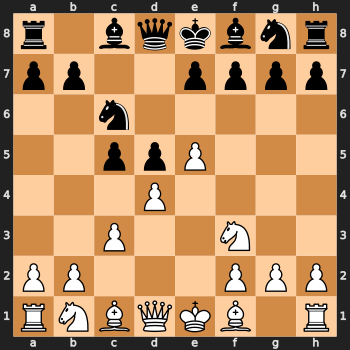

Position: https://lichess.org/0zZJQBHT#11
path: ./zoutput/ name: 0zZJQBHT.txt


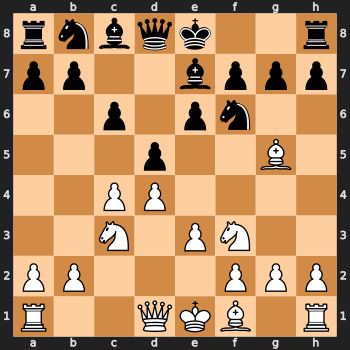

Position: https://lichess.org/ClHiXlvN#7
path: ./zoutput/ name: ClHiXlvN.txt


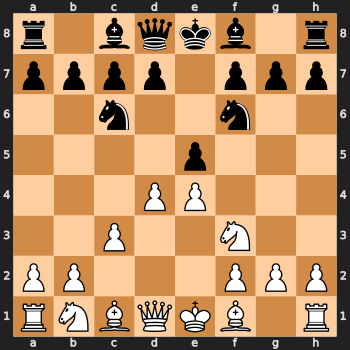

Position: https://lichess.org/LGyoyzB7#17
path: ./zoutput/ name: LGyoyzB7.txt


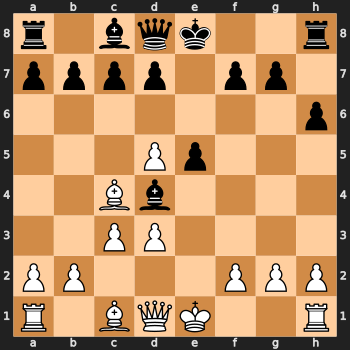

Position: https://lichess.org/kLKqVm2U#7
path: ./zoutput/ name: kLKqVm2U.txt


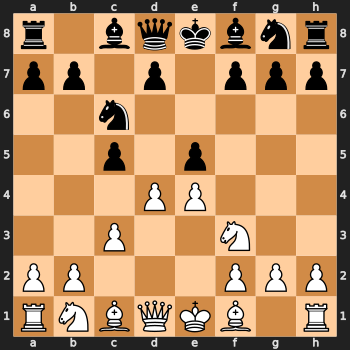

Position: https://lichess.org/VHpl3CXA#5
path: ./zoutput/ name: VHpl3CXA.txt


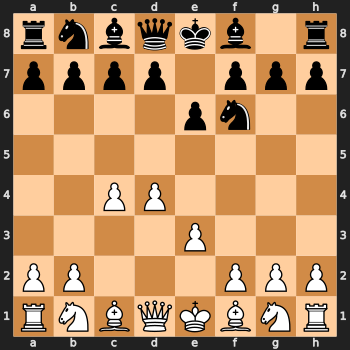

Position: https://lichess.org/MZXpdXOI#9
path: ./zoutput/ name: MZXpdXOI.txt


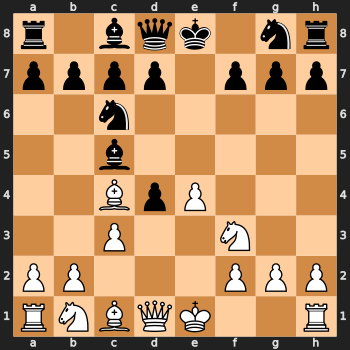

Position: https://lichess.org/QGiYEwHX#27
path: ./zoutput/ name: QGiYEwHX.txt


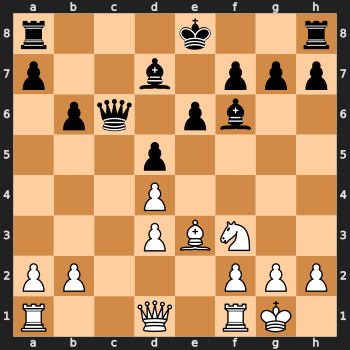

Position: https://lichess.org/KEjC1GXH#31
path: ./zoutput/ name: KEjC1GXH.txt


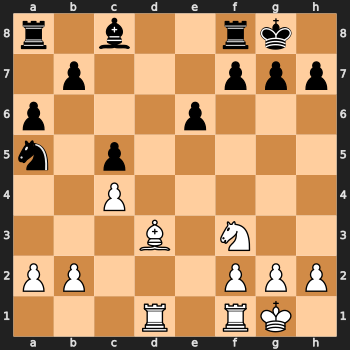

Position: https://lichess.org/mrowWi6j#15
path: ./zoutput/ name: mrowWi6j.txt


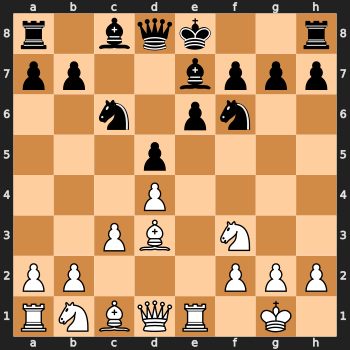

Position: https://lichess.org/4IJo4DlS#5
path: ./zoutput/ name: 4IJo4DlS.txt


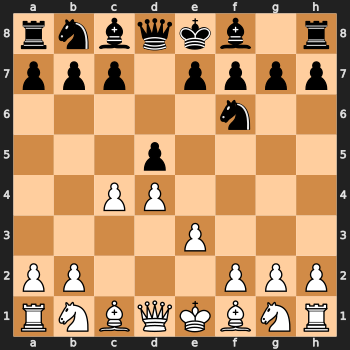

Position: https://lichess.org/TNhoEPXL#7
path: ./zoutput/ name: TNhoEPXL.txt


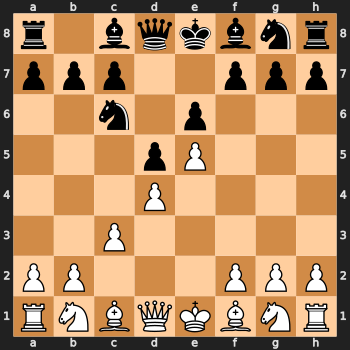

Position: https://lichess.org/vsHTMLbd#7
path: ./zoutput/ name: vsHTMLbd.txt


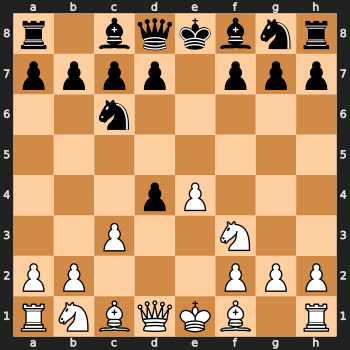

Position: https://lichess.org/nkerfwVx#25
path: ./zoutput/ name: nkerfwVx.txt


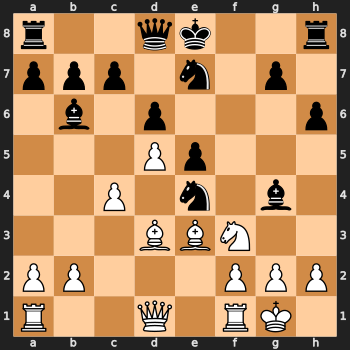

In [58]:
# Do searching on it:
#!/usr/bin/env python

INDEX_DIR = "Chess.index"

import sys, os, lucene

from java.nio.file import Paths
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.store import NIOFSDirectory
from org.apache.lucene.search import IndexSearcher

"""
This script is loosely based on the Lucene (java implementation) demo class
org.apache.lucene.demo.SearchFiles.  It will prompt for a search query, then it
will search the Lucene index in the current directory called 'index' for the
search query entered against the 'contents' field.  It will then display the
'path' and 'name' fields for each of the hits it finds in the index.  Note that
search.close() is currently commented out because it causes a stack overflow in
some cases.
"""
def run(searcher, analyzer, command):
    # while True:
        # print()
        # print("Hit enter with no input to quit.")
        # command = input("Query:")
        # if command == '':
        #     return

    print ("Searching for:", command)
    query = QueryParser("contents", analyzer).parse(command)
    scoreDocs = searcher.search(query, 50).scoreDocs
    print ("%s total matching documents." % len(scoreDocs))

    for scoreDoc in scoreDocs:
        doc = searcher.doc(scoreDoc.doc)
        print
        
        # print ('path:', doc.get("path"), 'name:', doc.get("name"))

        # Get the content of the document
        path = os.path.join(doc.get("path"), doc.get("name"))
        file = open(path)
        content = str(file.read())
        file.close()
        i = 1
        for line in content.split("\n"):
            if command in line:
                print(f"Position: https://lichess.org/{doc.get('name').split('.')[0]}#{i}")
                print ('path:', doc.get("path"), 'name:', doc.get("name"))
                import chess.svg
                board = chess.Board(line)
                display(chess.svg.board(board, size=350))
                break
            i += 1
        # print(doc.get("path"),doc.get("name"))
        # content = doc.get("name")
        # lines = content.split("\n")

        # # Find the line that contains the match
        # for i, line in enumerate(lines):
        #     if command in line:
        #         print("Found match on line", i)


# if __name__ == '__main__':
# lucene.initVM(vmargs=['-Djava.awt.headless=true'])
print( 'lucene', lucene.VERSION)
base_dir = os.path.dirname("/Users/tobiaswilfert/Documents/University/IR/chess-db/test.ipynb")
directory = NIOFSDirectory(Paths.get(os.path.join(base_dir, INDEX_DIR)))
searcher = IndexSearcher(DirectoryReader.open(directory))
analyzer = StandardAnalyzer()
run(searcher, analyzer, command="PP3PPP")
del searcher


## Conclusion

We are able to look up specific rows in the DB using the FEN Notation. Even better we can find the exact position in the game that matches the query can can hence reconstruct the url to that specific game position on Lichess. This is great since the Lichess Editor is better for examining a single game than anything we could build ourselves in a notebook.